In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

In [2]:
# === Carga de datos procesados desde la etapa de selección de características ===

# Carga del dataset con características seleccionadas por criterio fuzzy
X_fuzzy = pd.read_csv("13_X_fuzzy_filtrado_final.csv")
y = pd.read_csv("06_y_labels.csv")

print("✅ Dataset X_fuzzy cargado correctamente.")
print(f"Dimensiones: {X_fuzzy.shape}")
print(f"Columnas: {list(X_fuzzy.columns)}")

# Validación de índice y alineación
assert len(X_fuzzy) == len(y), "X e y deben tener la misma longitud"

X_fuzzy["label"] = y.values.ravel()  # Asegura columna de destino

DF = X_fuzzy.copy()

✅ Dataset X_fuzzy cargado correctamente.
Dimensiones: (221038, 6)
Columnas: ['Application_Category_Name', 'Src2dst_Max_Ps', 'Dst2src_Packets', 'Dst2src_Mean_Piat_Ms', 'Bidirectional_Max_Piat_Ms', 'Bidirectional_Min_Ps']


In [3]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ─────────────────────────────────────────────
# DATA PREPARATION  ·  Categorical mappings
# ─────────────────────────────────────────────
def build_categorical_codes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Añade codificaciones numéricas a variables categóricas clave:
    - 'App_Cat_Code' a partir de 'Application_Category_Name'
    """
    
    # ---- Application category → entero ordenado alfabéticamente
    categorias = sorted(df['Application_Category_Name'].unique())
    # Se extraen las categorías únicas y se ordenan alfabéticamente.
    # Esto garantiza una codificación determinista entre ejecuciones.

    cat2code = {cat: idx for idx, cat in enumerate(categorias)}
    # Asignación de un código entero incremental a cada categoría textual.

    df['App_Cat_Code'] = df['Application_Category_Name'].map(cat2code)
    # Se crea la nueva columna codificada. Este paso permite que modelos y sistemas difusos
    # trabajen con variables originalmente no numéricas.

    return df
    # Devuelve el DataFrame con columnas nuevas y listas para ser utilizadas en lógica difusa o modelado.

# Aplicación directa de la función al DataFrame 'df'
df = build_categorical_codes(DF)
# Este paso asegura que el DataFrame tenga todas las codificaciones requeridas para procesos posteriores,
# como definición de variables lingüísticas en sistemas fuzzy o entradas numéricas en modelos ML.

In [4]:
# ─────────────────────────────────────────────
# 1.  NUMERICAL ANTECEDENTS
# ─────────────────────────────────────────────
pps_max = ctrl.Antecedent(np.arange(50, 50001, 50), 'Src2dst_Max_Ps')
pps_max['baja']  = fuzz.trapmf(pps_max.universe, [50, 60, 150, 300])
pps_max['media'] = fuzz.trimf(pps_max.universe,  [150, 400, 1600])
pps_max['alta']  = fuzz.trapmf(pps_max.universe, [1200, 5000, 50000, 50000])

pkt = ctrl.Antecedent(np.arange(0, 23001, 10), 'Dst2src_Packets')
pkt['baja']  = fuzz.trapmf(pkt.universe,  [0, 0, 1, 5])
pkt['media'] = fuzz.trimf(pkt.universe,   [1, 50, 200])
pkt['alta']  = fuzz.trapmf(pkt.universe,  [150, 500, 23000, 23000])

piat = ctrl.Antecedent(np.arange(0, 20001, 1), 'Dst2src_Mean_Piat_Ms')
piat['critica'] = fuzz.trapmf(piat.universe, [0, 0, 1, 6000])
piat['media']   = fuzz.trimf(piat.universe,  [4000, 10000, 16000])
piat['alta']    = fuzz.trapmf(piat.universe, [15000, 19000, 20000, 20000])

piat_max = ctrl.Antecedent(np.arange(0, 15001, 1), 'Bidirectional_Max_Piat_Ms')
piat_max['muy_baja'] = fuzz.trapmf(piat_max.universe, [0, 0, 5, 20])
piat_max['media']    = fuzz.trimf(piat_max.universe,  [10, 200, 2000])
piat_max['alta']     = fuzz.trapmf(piat_max.universe, [1500, 5000, 15000, 15000])

pps_min = ctrl.Antecedent(np.arange(0, 2001, 5), 'Bidirectional_Min_Ps')
pps_min['baja']  = fuzz.trapmf(pps_min.universe, [0, 0, 20, 80])
pps_min['media'] = fuzz.trimf(pps_min.universe,  [60, 120, 300])
pps_min['alta']  = fuzz.trapmf(pps_min.universe, [250, 500, 2000, 2000])

# ─────────────────────────────────────────────
# 2.  CATEGORICAL ANTECEDENTS
# ─────────────────────────────────────────────
# Application Category → App_Cat_Code  (0-24)
app_cat = ctrl.Antecedent(np.arange(0, 25, 1), 'App_Cat_Code')
app_cat['infraestructura'] = fuzz.trapmf(app_cat.universe, [0, 0, 2, 3])
app_cat['web']             = fuzz.trapmf(app_cat.universe, [4, 4, 6, 7])
app_cat['iot']             = fuzz.trapmf(app_cat.universe, [8, 8, 9, 9])
app_cat['comunicacion']    = fuzz.trapmf(app_cat.universe, [10, 10, 11, 12])
app_cat['otros']           = fuzz.trapmf(app_cat.universe, [13, 15, 20, 24])

# ─────────────────────────────────────────────
# 3.  LISTA DEFINITIVA DE FEATURES A USAR
# ─────────────────────────────────────────────
features_fuzzy_final = [
    'Application_Category_Name',
    'Src2dst_Max_Ps',
    'Dst2src_Packets',
    'Dst2src_Mean_Piat_Ms',
    'Bidirectional_Max_Piat_Ms',
    'Bidirectional_Min_Ps'
]

# ================================
# VARIABLE DE SALIDA
# ================================

ddos_risk = ctrl.Consequent(np.arange(0, 101, 1), 'Traffic_Class')
ddos_risk['normal']     = fuzz.trapmf(ddos_risk.universe, [0, 0, 30, 40])
ddos_risk['sospechoso'] = fuzz.trimf(ddos_risk.universe, [35, 50, 65])
ddos_risk['ddos']       = fuzz.trapmf(ddos_risk.universe, [60, 75, 100, 100])


c:\Users\USUARIO\anaconda3\envs\tfm\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 700x400 with 0 Axes>

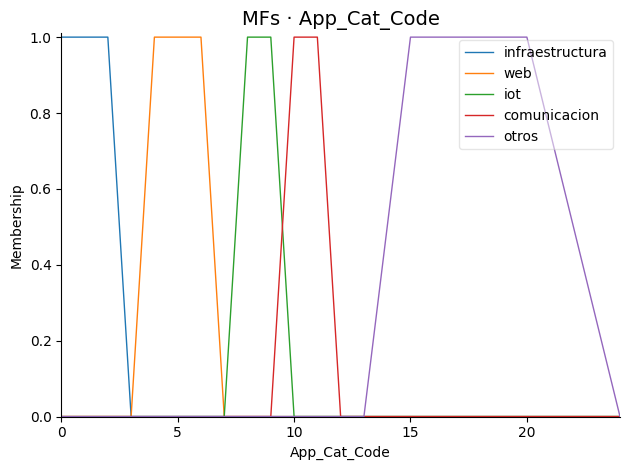

<Figure size 700x400 with 0 Axes>

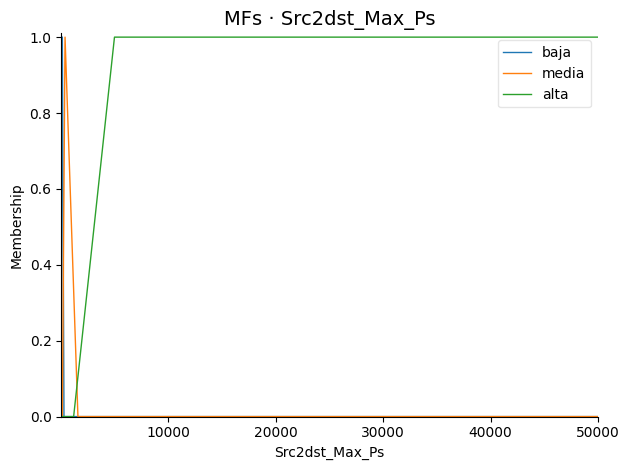

<Figure size 700x400 with 0 Axes>

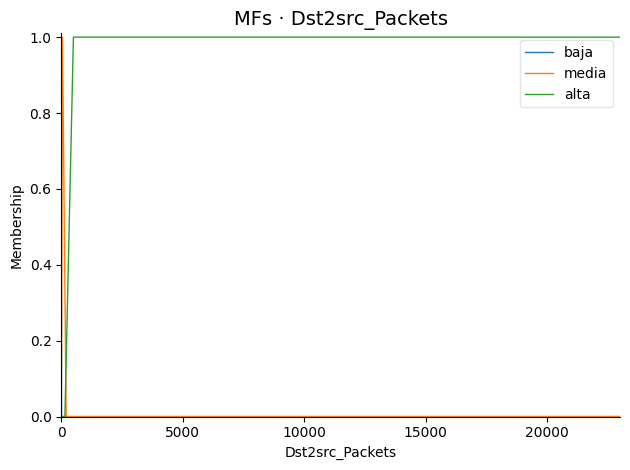

<Figure size 700x400 with 0 Axes>

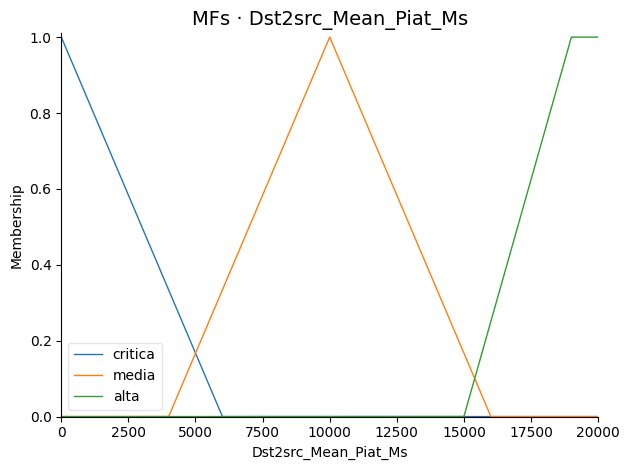

<Figure size 700x400 with 0 Axes>

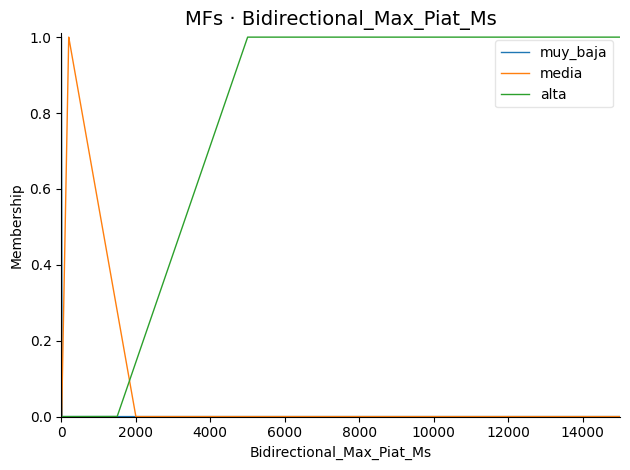

<Figure size 700x400 with 0 Axes>

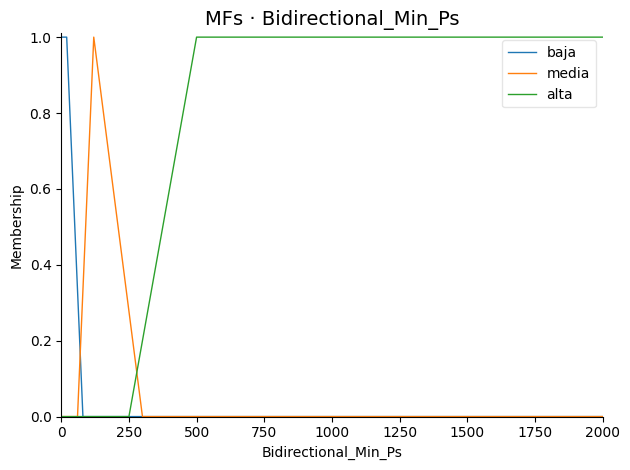

<Figure size 700x400 with 0 Axes>

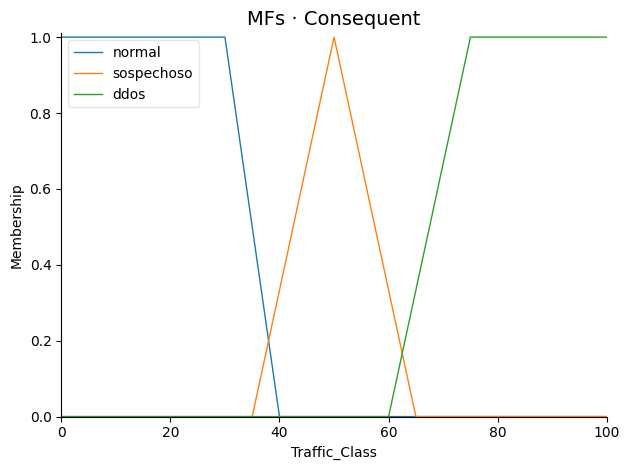

In [5]:
# -----------------------------------------------------------
# VISUALIZAR TODAS LAS FUNCIONES DE PERTENENCIA DEFINIDAS
# -----------------------------------------------------------
import matplotlib.pyplot as plt
from pathlib import Path

# 1)  LISTA DE OBJETOS A GRAFICAR
antecedents = {
    'App_Cat_Code'              : app_cat,
    'Src2dst_Max_Ps'            : pps_max,
    'Dst2src_Packets'           : pkt,
    'Dst2src_Mean_Piat_Ms'      : piat,
    'Bidirectional_Max_Piat_Ms' : piat_max,
    'Bidirectional_Min_Ps'      : pps_min
}
consequent = ddos_risk   # variable de salida

# 2)  FUNCIÓN AUXILIAR
def show_membership(ant_dict, cons=None, save=False, out_dir="mf_plots"):
    """
    Muestra (y opcionalmente guarda) las curvas de pertenencia
    de todos los Antecedents y del Consequent.
    
    Parameters
    ----------
    ant_dict : dict[str, ctrl.Antecedent]
        Nombre lógico → objeto Antecedent.
    cons : ctrl.Consequent | None
        Consequent a graficar (o None para omitir).
    save : bool
        True → guarda cada figura como .png en `out_dir`.
    out_dir : str
        Carpeta de salida.
    """
    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
    
    # -- Antecedentes
    for name, ant in ant_dict.items():
        plt.figure(figsize=(7, 4))
        ant.view()
        plt.title(f"MFs · {name}", fontsize=14)
        plt.tight_layout()
        if save:
            plt.savefig(f"{out_dir}/{name}.png", dpi=150)
        plt.show(block=False)
    
    # -- Consecuente
    if cons is not None:
        plt.figure(figsize=(7, 4))
        cons.view()
        plt.title("MFs · Consequent", fontsize=14)
        plt.tight_layout()
        if save:
            plt.savefig(f"{out_dir}/consequent.png", dpi=150)
        plt.show(block=False)

# 3)  LLAMADA ÚNICA
show_membership(antecedents, consequent, save=False)


In [6]:
from skfuzzy import control as ctrl

rules = [

    # R1 – Anomalía volumétrica con PPS alto y paquetes entrantes elevados
    ctrl.Rule(pps_max['alta'] & pkt['alta'],
              ddos_risk['ddos'], label='R1_volumen_pkt'),

    # R2 – Comportamiento sospechoso por retardo medio y PPS bajo
    ctrl.Rule(piat['media'] & pps_max['baja'],
              ddos_risk['sospechoso'], label='R2_laten_baja'),

    # R3 – Pico extremo de latencia en una dirección (anomalía)
    ctrl.Rule(piat_max['alta'] & pkt['baja'],
              ddos_risk['sospechoso'], label='R3_laten_spike'),

    # R4 – Tráfico mínimo y regular en contexto web
    ctrl.Rule(app_cat['web'] & pps_max['media'] & pkt['media'],
              ddos_risk['normal'], label='R4_web_regular'),

    # R5 – IoT telemetría habitual: app tipo IoT + bajo PPS + pocos paquetes
    ctrl.Rule(app_cat['iot'] & pps_max['baja'] & pkt['baja'],
              ddos_risk['normal'], label='R5_iot_ok'),

    # R6 – Flujo mínimo con tamaño pequeño de paquetes → indicio de anomalía leve
    ctrl.Rule(pps_min['baja'] & pkt['media'],
              ddos_risk['sospechoso'], label='R6_min_pkt'),

    # R7 – PPS muy alto, independientemente de otros factores
    ctrl.Rule(pps_max['alta'],
              ddos_risk['ddos'], label='R7_pps_alta'),

    # R8 – Pico de latencia extremo (indicador de congestión o ataque)
    ctrl.Rule(piat_max['alta'],
              ddos_risk['ddos'], label='R8_pico_latencia'),

    # R9 – Pocas respuestas (pkt bajo) pero tráfico de salida elevado (pps alta)
    ctrl.Rule(pkt['baja'] & pps_max['alta'],
              ddos_risk['ddos'], label='R9_pkt_bajo_pps_alto')
]

# ───────────────────────────────────────────
#  CONSTRUCCIÓN DEL SISTEMA DIFUSO
# ───────────────────────────────────────────

fuzzy_ddos_ctrl = ctrl.ControlSystem(rules)
fuzzy_ddos_sim = ctrl.ControlSystemSimulation(fuzzy_ddos_ctrl)

print(f"✅ Sistema Mamdani creado con {len(rules)} reglas.")


✅ Sistema Mamdani creado con 9 reglas.


In [7]:
# Cargar el conjunto completo con codificación y etiquetas
df_full = build_categorical_codes(X_fuzzy.copy())  # asegúrese que 'App_Cat_Code' esté
df_full["label"] = y.values.ravel()  # 0 = benigno, 1 = ataque

# Resultado por simulación
resultados = []

# Rango categorizado de salida difusa
def clasificar_trafico(valor):
    if valor < 40:
        return 'normal'
    elif 40 <= valor < 70:
        return 'sospechoso'
    else:
        return 'ddos'


In [8]:
from tqdm import tqdm  # para seguimiento visual del progreso

for _, row in tqdm(df_full.iterrows(), total=len(df_full)):
    # Preparar entrada
    fuzzy_ddos_sim.input['App_Cat_Code']            = row['App_Cat_Code']
    fuzzy_ddos_sim.input['Src2dst_Max_Ps']          = row['Src2dst_Max_Ps']
    fuzzy_ddos_sim.input['Dst2src_Packets']         = row['Dst2src_Packets']
    fuzzy_ddos_sim.input['Dst2src_Mean_Piat_Ms']    = row['Dst2src_Mean_Piat_Ms']
    fuzzy_ddos_sim.input['Bidirectional_Max_Piat_Ms'] = row['Bidirectional_Max_Piat_Ms']
    fuzzy_ddos_sim.input['Bidirectional_Min_Ps']    = row['Bidirectional_Min_Ps']

    # Computar inferencia
    try:
        fuzzy_ddos_sim.compute()
        salida = fuzzy_ddos_sim.output['Traffic_Class']
        clase_predicha = clasificar_trafico(salida)
    except:
        salida = None
        clase_predicha = 'error'

    resultados.append({
        'trafico_difuso': salida,
        'clasificacion': clase_predicha,
        'real': 'ddos' if row['label'] == 1 else 'normal'
    })


100%|██████████| 221038/221038 [07:13<00:00, 509.40it/s] 


In [ ]:
import pandas as pd

# Convertir la lista de resultados a un DataFrame
df_resultados = pd.DataFrame(resultados)

# Mapeo binario de la salida difusa
def map_difusa_a_binaria(clasificacion):
    if clasificacion == 'ddos':
        return 1  # Ataque
    else:
        return 0  # Tráfico normal o sospechoso

# Agregar columnas binarizadas
df_resultados['y_pred_binario'] = df_resultados['clasificacion'].map(map_difusa_a_binaria)
df_resultados['y_true_binario'] = df_resultados['real'].map(lambda x: 1 if x == 'ddos' else 0)

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Matriz de confusión (Binaria):")
print(confusion_matrix(df_resultados['y_true_binario'], df_resultados['y_pred_binario']))

print("\n📋 Informe de clasificación binaria:")
print(classification_report(
    df_resultados['y_true_binario'],
    df_resultados['y_pred_binario'],
    target_names=["normal", "ddos"]
))



📊 Matriz de confusión (Binaria):
[[81051 29468]
 [61731 48788]]

📋 Informe de clasificación binaria:
              precision    recall  f1-score   support

      normal       0.57      0.73      0.64    110519
        ddos       0.62      0.44      0.52    110519

    accuracy                           0.59    221038
   macro avg       0.60      0.59      0.58    221038
weighted avg       0.60      0.59      0.58    221038



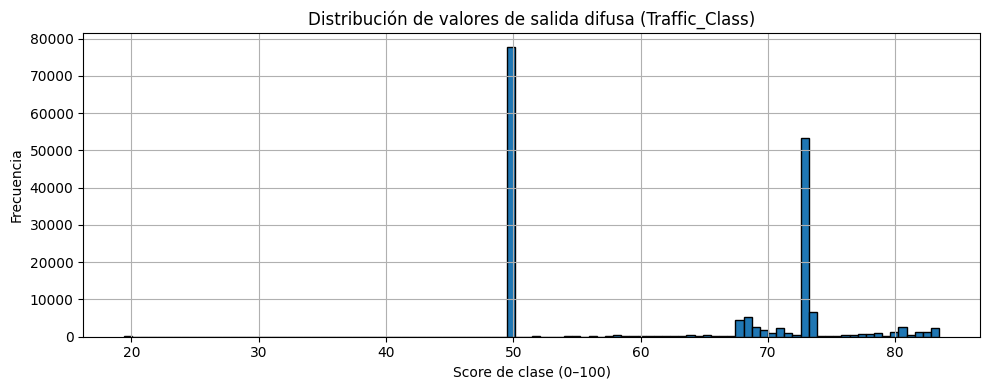

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
df_resultados['trafico_difuso'].dropna().hist(bins=100, edgecolor='black')
plt.title("Distribución de valores de salida difusa (Traffic_Class)")
plt.xlabel("Score de clase (0–100)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

for threshold in [30, 40, 50, 60, 70]:
    print(f"\n🔎 Evaluación con umbral: {threshold}")
    
    df_resultados['pred_bin'] = df_resultados['trafico_difuso'] > threshold
    df_resultados['true_bin'] = df_resultados['real'].map(lambda x: x == 'ddos')

    cm = confusion_matrix(df_resultados['true_bin'], df_resultados['pred_bin'])
    print("Matriz de confusión:")
    print(cm)

    print("\nInforme de clasificación:")
    print(classification_report(
        df_resultados['true_bin'],
        df_resultados['pred_bin'],
        target_names=["normal", "ddos"]
    ))



🔎 Evaluación con umbral: 30
Matriz de confusión:
[[33549 76970]
 [13476 97043]]

Informe de clasificación:
              precision    recall  f1-score   support

      normal       0.71      0.30      0.43    110519
        ddos       0.56      0.88      0.68    110519

    accuracy                           0.59    221038
   macro avg       0.64      0.59      0.55    221038
weighted avg       0.64      0.59      0.55    221038


🔎 Evaluación con umbral: 40
Matriz de confusión:
[[33549 76970]
 [13478 97041]]

Informe de clasificación:
              precision    recall  f1-score   support

      normal       0.71      0.30      0.43    110519
        ddos       0.56      0.88      0.68    110519

    accuracy                           0.59    221038
   macro avg       0.64      0.59      0.55    221038
weighted avg       0.64      0.59      0.55    221038


🔎 Evaluación con umbral: 50
Matriz de confusión:
[[49610 60909]
 [33481 77038]]

Informe de clasificación:
              precisio

In [18]:
def clasificar_ternario(score):
    if score < 40:
        return 'normal'
    elif score < 70:
        return 'sospechoso'
    else:
        return 'ddos'

# Asegura que estás operando sobre el DataFrame correcto
df_resultados = pd.DataFrame(resultados)

# Clasificación ternaria
df_resultados['pred_3'] = df_resultados['trafico_difuso'].apply(clasificar_ternario)

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Matriz de confusión (Ternaria):")
print(confusion_matrix(df_resultados['real'], df_resultados['pred_3'], labels=['normal', 'sospechoso', 'ddos']))

print("\n📋 Informe de clasificación ternaria:")
print(classification_report(
    df_resultados['real'],
    df_resultados['pred_3'],
    target_names=["normal", "sospechoso", "ddos"]
))



📊 Matriz de confusión (Ternaria):
[[   19 47502 62998]
 [    0     0     0]
 [   71 48253 62195]]

📋 Informe de clasificación ternaria:


c:\Users\USUARIO\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USUARIO\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      normal       0.50      0.56      0.53    110519
  sospechoso       0.21      0.00      0.00    110519
        ddos       0.00      0.00      0.00         0

    accuracy                           0.28    221038
   macro avg       0.24      0.19      0.18    221038
weighted avg       0.35      0.28      0.26    221038



c:\Users\USUARIO\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
